# In Silico RNA Aptamer Design
### Alexander Wang - 18.337 Final Project

In [28]:
using LinearAlgebra, Random, BenchmarkTools, PyCall, Plots

### Utility Functions

In [ ]:
# Actual structure prediction and similarity functions calling Python functions
# Unfortunately, multi-threading does not work with PyCall
py"""
def infer_structure(seq):
    # Returns pdb format tertiary structure prediction given an RNA sequence input
    # <Adapted from https://github.com/RFOLD/RhoFold>
    # <Specific code omitted as it has not yet been made public by our lab and collaborators>
    return output_file_path

def compute_structural_similarity(ts1, ts2):
    # Computes a numerical similarity score given two structural pdb files (via file paths)
    # <Code omitted as it has not yet been made public by our collaborators>
    return similarity_score
"""

In [10]:
rna_bases = ['A', 'U', 'C', 'G']

function base_index(b)
    if b == 'A'
        return 1
    elseif b == 'U'
        return 2
    elseif b == 'C'
        return 3
    else
        return 4
    end
end

base_index (generic function with 1 method)

In [5]:
# Simple Julia structural prediction function for demonstration
function infer_structure(seq)
    prod = 1
    for b in seq
        prod *= base_index(b)
    end
    return prod
end

infer_structure (generic function with 1 method)

In [6]:
# Simple Julia structural similarity function for demonstration
function compute_structural_similarity(ts1, ts2)
    return abs(ts1 - ts2)
end

compute_structural_similarity (generic function with 1 method)

### Single-Threaded Sequence Space Search

In [7]:
"""
Determines the single base pair mutation which improves tertiary structual similarity 
to target the most.
"""
function mutate(initial_sequence, target_structure_path)
    # Set up array to track all mutations
    s = initial_sequence
    sim_scores = zeros(4, length(initial_sequence))
    
    # Fill entries corresponding to current sequence
    # ts = py"infer_structure"(s)
    # sc = py"compute_structural_similarity"(target_structure_path, ts)
    ts = infer_structure(s)
    sc = compute_structural_similarity(target_structure_path, ts)
    
    for i in 1:length(initial_sequence)
        sim_scores[base_index(s[i]), i] = sc
    end
    
    # Compute tertiary structural similarity for all single base pair mutations
    for i in 1:length(initial_sequence)
        for b in rna_bases
            if s[i] != b
                # ts = py"infer_structure"(string(s[1:i-1], b, s[i+1:end]))
                # sc = py"compute_structural_similarity"(target_structure_path, ts)
                ts = infer_structure(string(s[1:i-1], b, s[i+1:end]))
                sc = compute_structural_similarity(target_structure_path, ts)
                sim_scores[base_index(b), i] = sc
            end
        end
    end
    
    # Determine mutation that improves structural similarity to target structure the most
    min_diff = findmin(sim_scores)
    idx_min = min_diff[2]
    
    return min_diff[1], rna_bases[idx_min[1]], idx_min[2]
end

mutate

In [17]:
function search(initial_sequence, target_structure_path, max_iterations)
    # ts = py"infer_structure"(initial_sequence)
    # cur_sim = py"compute_structural_similarity"(target_structure_path, ts)
    ts = infer_structure(initial_sequence)
    cur_sim = compute_structural_similarity(target_structure_path, ts)
    
    cur_seq = initial_sequence
    
    for i in 1:max_iterations
        new_sim, new_base, pos = mutate(cur_seq, target_structure_path)
        
        if cur_sim == new_sim
        #    println("Converged, Current Sequence: $cur_seq")
            break
        end
        
        #if i % 10 == 0
        #    println("Iteration: $i, Current Sequence: $cur_seq")
        #end
        
        cur_sim = new_sim
        cur_seq = string(cur_seq[1:pos-1], new_base, cur_seq[pos+1:end])
    end
    
    #println("Reached Maximum Iterations, Current Sequence: $cur_seq")
end

search (generic function with 1 method)

In [18]:
@benchmark search("GGGAGAUUCCGUUUUCAGUCGGGAAAAACUGAA", 0, 100)

BenchmarkTools.Trial: 1172 samples with 1 evaluation.
 Range (min … max):  3.552 ms …   8.892 ms  ┊ GC (min … max): 0.00% … 51.51%
 Time  (median):     4.238 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.260 ms ± 521.851 μs  ┊ GC (mean ± σ):  1.26% ±  5.60%

  ▂ ▁▁▁ ▁▇█▇▄▁                                                 
  ████████████▇▇▅▆▁▁▅▆▁▅▄▁▁▁▁▁▁▄▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▅ █
  3.55 ms      Histogram: log(frequency) by time      8.21 ms <

 Memory estimate: 907.15 KiB, allocs estimate: 41034.

### Multi-Threaded Sequence Space Search

In [14]:
Threads.nthreads()

16

In [19]:
"""
Determines the single base pair mutation which improves tertiary structual similarity 
to target the most.
"""
function mutate_par(initial_sequence, target_structure_path)
    # Set up array to track all mutations
    s = initial_sequence
    sim_scores = zeros(4, length(initial_sequence))
    
    # Fill entries corresponding to current sequence
    # ts = py"infer_structure"(s)
    # sc = py"compute_structural_similarity"(target_structure_path, ts)
    ts = infer_structure(s)
    sc = compute_structural_similarity(target_structure_path, ts)
    
    for i in 1:length(initial_sequence)
        sim_scores[base_index(s[i]), i] = sc
    end
    
    # Compute tertiary structural similarity for all single base pair mutations
    Threads.@threads for i in 1:length(initial_sequence)
        for b in rna_bases
            if s[i] != b
                # ts = py"infer_structure"(string(s[1:i-1], b, s[i+1:end]))
                # sc = py"compute_structural_similarity"(target_structure_path, ts)
                ts = infer_structure(string(s[1:i-1], b, s[i+1:end]))
                sc = compute_structural_similarity(target_structure_path, ts)
                sim_scores[base_index(b), i] = sc
            end
        end
    end
    
    # Determine mutation that improves structural similarity to target structure the most
    min_diff = findmin(sim_scores)
    idx_min = min_diff[2]
    
    return min_diff[1], rna_bases[idx_min[1]], idx_min[2]
end

mutate_par

In [20]:
function search_par(initial_sequence, target_structure_path, max_iterations)
    # ts = py"infer_structure"(initial_sequence)
    # cur_sim = py"compute_structural_similarity"(target_structure_path, ts)
    ts = infer_structure(initial_sequence)
    cur_sim = compute_structural_similarity(target_structure_path, ts)
    
    cur_seq = initial_sequence
    
    for i in 1:max_iterations
        new_sim, new_base, pos = mutate_par(cur_seq, target_structure_path)
        
        if cur_sim == new_sim
            #println("Converged, Current Sequence: $cur_seq")
            break
        end
        
        #if i % 10 == 0
        #    println("Iteration: $i, Current Sequence: $cur_seq")
        #end
        
        cur_sim = new_sim
        cur_seq = string(cur_seq[1:pos-1], new_base, cur_seq[pos+1:end])
    end
    
    #println("Reached Maximum Iterations, Current Sequence: $cur_seq")
end

search_par (generic function with 1 method)

In [27]:
@benchmark search_par("GGGAGAUUCCGUUUUCAGUCGGGAAAAACUGAA", 0, 100)

BenchmarkTools.Trial: 1811 samples with 1 evaluation.
 Range (min … max):  948.655 μs … 41.415 ms  ┊ GC (min … max): 0.00% … 88.40%
 Time  (median):       2.195 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):     2.752 ms ±  3.163 ms  ┊ GC (mean ± σ):  5.23% ±  6.15%

   ▁█▇▅▅▄▁                                                      
  ▆███████▆▄▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▂▂▂▁▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▂ ▃
  949 μs          Histogram: frequency by time         17.4 ms <

 Memory estimate: 1.13 MiB, allocs estimate: 46579.

### Further Parallelization

In [25]:
function multi_search(initial_sequences, target_structure_path, max_iterations)
    # Search from multiple starting sequences
    for seq in initial_sequences
        search(seq, target_structure_path, max_iterations)
    end
end

multi_search (generic function with 1 method)

In [23]:
function multi_search_par(initial_sequences, target_structure_path, max_iterations)
    # Search from multiple starting sequences
    Threads.@threads for seq in initial_sequences
        search_par(seq, target_structure_path, max_iterations)
    end
end

multi_search_par (generic function with 1 method)

In [26]:
@benchmark multi_search(["GGGAGAUUCCGUUUUCAGUCGGGAAAAACUGAA", "UCAAGAAUUCCGUUUUCAGUCGGGAAAAACUGA", "UCAAGAAUACCGUGCUCAGUCGGGATGAACUGA"], 0, 100)

BenchmarkTools.Trial: 400 samples with 1 evaluation.
 Range (min … max):  10.625 ms … 17.991 ms  ┊ GC (min … max): 0.00% … 29.56%
 Time  (median):     12.561 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.491 ms ±  1.072 ms  ┊ GC (mean ± σ):  1.28% ±  4.84%

                    █▅                                         
  ▂▃▃▄▄▅▄▃▄▃▃▃▂▄▅█▆▇██▄▃▃▁▂▂▁▁▃▃▃▁▃▂▁▁▁▁▁▁▁▁▂▁▁▁▂▂▂▁▁▁▁▁▂▂▂▃▂ ▃
  10.6 ms         Histogram: frequency by time          17 ms <

 Memory estimate: 2.57 MiB, allocs estimate: 118048.

In [24]:
@benchmark multi_search_par(["GGGAGAUUCCGUUUUCAGUCGGGAAAAACUGAA", "UCAAGAAUUCCGUUUUCAGUCGGGAAAAACUGA", "UCAAGAAUACCGUGCUCAGUCGGGATGAACUGA"], 0, 100)

BenchmarkTools.Trial: 895 samples with 1 evaluation.
 Range (min … max):  1.987 ms … 172.053 ms  ┊ GC (min … max): 0.00% … 98.19%
 Time  (median):     3.244 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.581 ms ±  10.064 ms  ┊ GC (mean ± σ):  9.24% ±  5.67%

  ▃▇█▇▅▄▃▃▁ ▁▂▁                                                
  █████████▇████▇█▇█▆█▇▇█▅▇▇█▇▆▆▅█▆▅▆█▇▅▇▅▄▄▄▄▁▄▁▄▁▁▁▄▄▅▁▅▁▄▅ █
  1.99 ms      Histogram: log(frequency) by time      22.6 ms <

 Memory estimate: 3.31 MiB, allocs estimate: 134656.

### Scientific Machine Learning to Augment Experimental Validation

In [3]:
using CSV, DataFrames, Flux, Zygote, Optimisers

#### Encode RNA Sequence Input Based on Biophysical Properties of RNA

In [4]:
"""
Encodes a string RNA sequence input via a one-hot encoding to facilitate scientific
machine learning informed by biophysics surrounding RNA (sequence-structure relation)
"""
function encode(s, first, last)
    s_repr = zeros(4, last - first + 1)
    for i in first:last
        s_repr[base_index(s[i]), i - first + 1] = 1
    end
    return vec(s_repr)
end

encode

#### Train Neural Network

In [34]:
function train_NN(data_x, data_y, n_data, target_len, n_epochs)
    NN = Chain(
            Dense(target_len * 4, target_len * 4),
            Dense(target_len * 4, 1),
            first)

    opt = Optimisers.Momentum(0.01)

    loss(x, y) = Flux.Losses.mse(NN(x), y)    

    opt_state = Flux.setup(ADAM(), NN)

    losses = []
    for epoch in 1:n_epochs
        for i in 1:n_data
            input, label = data_x[i,:], data_y[i]

            val, grads = Flux.withgradient(NN) do NN
                result = NN(input)
                Flux.Losses.mse(result, label)
            end

            Flux.update!(opt_state, NN, grads[1])
        end

        NN_loss = [loss(data_x[i,:], data_y[i]) for i in 1:n_data]
        m_loss = mean(NN_loss)
        push!(losses, m_loss)
        
        if epoch % 1000 == 0
            println("Epoch: $epoch, Loss: $m_loss")
        end
    end
    
    return NN, losses
end

train_NN (generic function with 1 method)

#### RNA Mango Aptamers

In [5]:
n_mango = 27
target_len_mango = 33
mango_df = DataFrame(CSV.File("data/mango_aptamers.csv"))[1:n_mango, :];

In [6]:
mango_x, mango_y = zeros(n_mango, target_len_mango * 4), mango_df[:,:Energy]
for i in 1:n_mango
    mango_x[i,:] = encode(mango_df[i,:Sequence],1,target_len_mango)
end

([0.0 0.0 … 1.0 0.0; 0.0 0.0 … 1.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 0.0 1.0], Union{Missing, Float64}[4.138737679, 5.39467907, 3.840708256, 5.049808979, 8.692469597, 11.39330196, 4.248609066, 5.02358532, 9.149440765, 9.141038895  …  9.856764793, 11.10178566, 10.85617733, 7.79658699, 9.957169533, 11.50224972, 7.582145214, 9.578351974, 11.95219231, 10.36016369])

In [35]:
NN_mango, losses_mango = train_NN(mango_x, mango_y, n_mango, target_len_mango, 10000)

Epoch: 1000, Loss: 0.09941898083908912
Epoch: 2000, Loss: 0.08194618739011614
Epoch: 3000, Loss: 0.08258902211773246
Epoch: 4000, Loss: 0.08320917743411795
Epoch: 5000, Loss: 0.0836644316889127
Epoch: 6000, Loss: 0.08010259336640997
Epoch: 7000, Loss: 0.08134383885281292
Epoch: 8000, Loss: 0.07907423893021624
Epoch: 9000, Loss: 0.08236791910652981
Epoch: 10000, Loss: 0.0786498425027161


(Chain(Dense(132 => 132), Dense(132 => 1), first), Any[11.313383978025643, 4.102981165945613, 2.632335689202109, 1.978376962345292, 1.7077140036115506, 1.5170916704874433, 1.3644086714850432, 1.2269214297527506, 1.1034686701338021, 0.9928200517169337  …  0.07919794500092694, 0.07830230249200973, 0.07968744876034632, 0.07888800828226616, 0.0777452039634743, 0.0795559764043561, 0.07944387263018261, 0.07957956875739604, 0.07873517934603508, 0.0786498425027161])

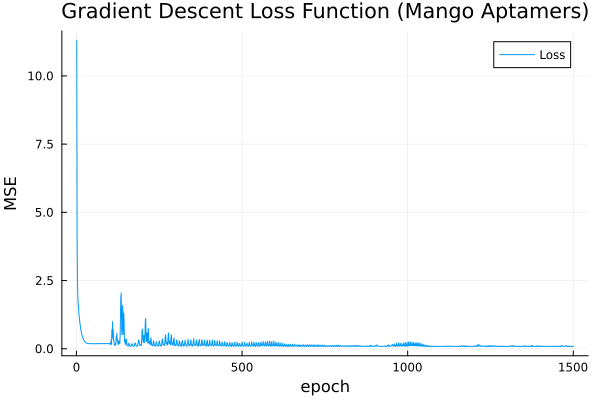

In [58]:
its = range(1, 1500)
plot(its, losses_mango[1:1500], title="Gradient Descent Loss Function (Mango Aptamers)", label="Loss")
xlabel!("epoch")
ylabel!("MSE")

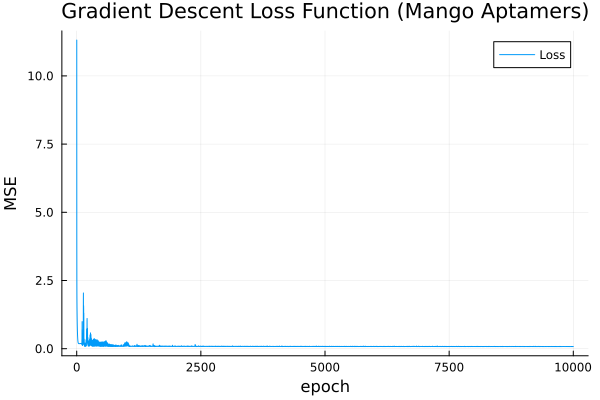

In [59]:
its = range(1, length(losses_mango))
plot(its, losses_mango, title="Gradient Descent Loss Function (Mango Aptamers)", label="Loss")
xlabel!("epoch")
ylabel!("MSE")

In [52]:
NN_mango[1].weight

132×132 Matrix{Float32}:
 -0.0225305  -0.0511865   -0.0487514  -0.0814793  …   0.0058281  -0.0329589
  0.0739932  -0.0779685    0.0317601   0.0288318     -0.0126327  -0.0570593
 -0.0450051   0.017707    -0.139801   -0.0899935     -0.0503539  -0.0555696
 -0.0793908  -0.00917667   0.107145    0.120564      -0.0348581   0.0400664
 -0.0979187   0.0387917   -0.0020412   0.131754      -0.0117427   0.0765099
  0.0949836  -0.112325    -0.0737891   0.141733   …  -0.0388456  -0.00309607
  0.0595229  -0.075249     0.0960363  -0.0692859     -0.050855    0.143155
 -0.120116   -0.0671537   -0.0137418  -0.121375       0.0536642  -0.0483151
 -0.0384619   0.118906     0.145921    0.0718276      0.0795378  -0.0878609
  0.0908993  -0.0730731    0.0337024   0.24801       -0.0162765   0.14338
  0.113628    0.120433    -0.0225389   0.255994   …  -0.0185462   0.403367
 -0.132344   -0.00829465   0.0643462   0.11164       -0.123584    0.0604732
 -0.0041565   0.0360194    0.092401    0.0937597     -0.0629488  -

In [53]:
NN_mango[2].weight

1×132 Matrix{Float32}:
 0.00238362  0.000655566  0.0022915  0.00151323  …  -1.56104f-5  -0.00112529

#### HIV Reverse Transcriptase Aptamers

In [7]:
n_hiv = 30
target_len_hiv = 31
hiv_df = DataFrame(CSV.File("data/hiv_aptamers.csv"))[1:n_hiv, :];

In [37]:
hiv_x, hiv_y = zeros(n_hiv, target_len_hiv * 4), hiv_df[:,:Energy]
for i in 1:n_hiv
    hiv_x[i,:] = encode(hiv_df[i,:Sequence],1,target_len_hiv)
end

In [40]:
NN_hiv, losses_hiv = train_NN(hiv_x, hiv_y, n_hiv, target_len_hiv, 10000)

Epoch: 1000, Loss: 0.9793873741813562
Epoch: 2000, Loss: 0.9771128153530452
Epoch: 3000, Loss: 0.9745821837774408
Epoch: 4000, Loss: 0.9740372163400932
Epoch: 5000, Loss: 0.9741562588743323
Epoch: 6000, Loss: 0.9753939509077705
Epoch: 7000, Loss: 0.9735848355421557
Epoch: 8000, Loss: 0.9732379225845535
Epoch: 9000, Loss: 0.973399485728795
Epoch: 10000, Loss: 0.9730811370093754


(Chain(Dense(124 => 124), Dense(124 => 1), first), Any[4.007232443201562, 1.6618183511272882, 1.3883492218093139, 1.2889884967944363, 1.2344757181482238, 1.1979417903515888, 1.1712089900678888, 1.1495932410855305, 1.1321994122385912, 1.1179505650471957  …  0.9773487339073825, 0.9760890141388882, 0.9750582365583061, 0.9742008671788366, 0.9735199175241047, 0.9731330201920279, 0.9730834853575229, 0.9730511482120019, 0.9729472333715279, 0.9730811370093754])

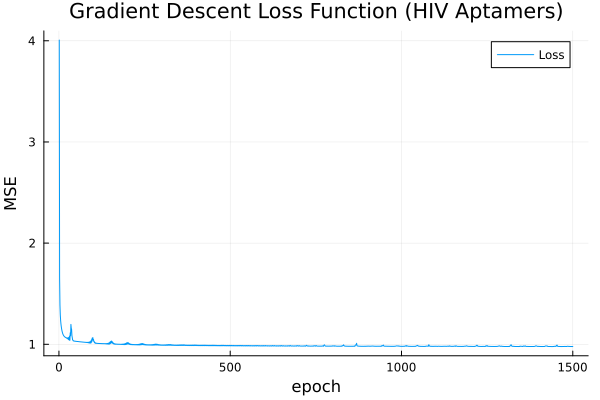

In [61]:
its = range(1, 1500)
plot(its, losses_hiv[1:1500], title="Gradient Descent Loss Function (HIV Aptamers)", label="Loss")
xlabel!("epoch")
ylabel!("MSE")

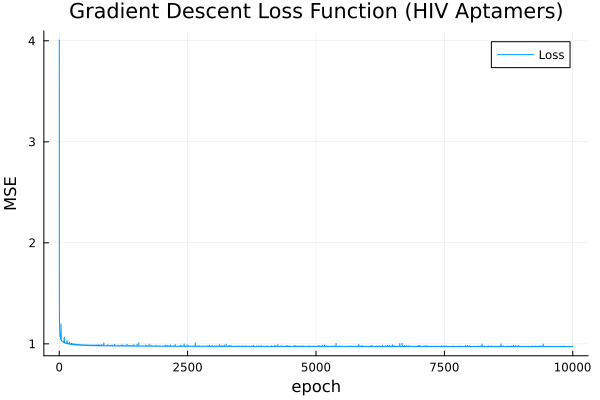

In [63]:
its = range(1, length(losses_hiv))
plot(its, losses_hiv, title="Gradient Descent Loss Function (HIV Aptamers)", label="Loss")
xlabel!("epoch")
ylabel!("MSE")

In [54]:
NN_hiv[1].weight

124×124 Matrix{Float32}:
  0.0026863    0.119918    -0.0947622   …  -0.00167805   0.0672895
  0.150245    -0.0334028   -0.0177902       0.13054     -0.0271353
 -0.0197552    0.00752559   0.0024998      -0.0149972   -0.0660472
 -0.00102886  -0.0327535    0.150787       -0.0119273    0.0233765
 -0.0808927   -0.0278226    0.137993        0.0342989   -0.0670428
 -0.0418351    0.132092    -0.0992063   …  -0.0505388   -0.0886135
  0.00842032  -0.0615555    0.107873       -0.0484223   -0.0683209
  0.0607857    0.119703     0.0806946       0.0701878   -0.096231
 -0.0560122    0.0876985   -0.00242157      0.0154841    0.134134
 -0.0742612   -0.0496518    0.00322906     -0.0146458   -0.0504918
  0.464037     0.0854217   -0.122953    …   0.240012     0.055973
  0.0340108   -0.102629    -0.125079       -0.0535266   -0.0565237
  0.0480671    0.129051    -0.0105986      -0.056159     0.00535783
  ⋮                                     ⋱               
 -0.00133103   0.0382168    0.078477        0.000

In [55]:
NN_hiv[2].weight

1×124 Matrix{Float32}:
 0.00036667  0.000118113  0.000168023  …  -2.5548f-5  -7.27947f-5